# Classiq Challenge Solution

Submitted by team Quantotto

In [1]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
import numpy as np
import math

In [52]:
def norm(a):
    return np.linalg.norm(a)

def normalize(a):
    return list(np.array(a) / norm(a))

def sqrt_sum(a):
    return np.sqrt(np.sum(np.array(a)))

def create_unitary(first_column):
    k = len(first_column)
    added_rows = []
    for i in range(k-1):
        row = [0] * k
        row[i] = 1
        added_rows.append(row)
    A = np.array([
        normalize(first_column),
        *added_rows
    ]).T
    n = A.shape[1]
    # Use Gram-Schmidt orthogonalization
    # Credits: https://www.mycompiler.io/view/Di9dsPfR4gy
    for i in range(1, n):
        for j in range(i):
            A[:, i] = A[:, i] - np.dot(A[:, j], A[:, i]) * A[:, j]
            A[:, i] = A[:, i] / np.linalg.norm(A[:, i])
    return A.tolist()

In [53]:
def calculate_Cs(x0, A, t, k):
    x0_norm = norm(x0)
    A_norm = norm(A)
    arr = [x0_norm * ((A_norm * t) ** i) / math.factorial(i) for i in range(k+1)]
    return arr

def calculate_V(Cs):
    return [[1, 0], [0, -1]]

def calculate_Vs1(Cs):
    first_row = normalize(np.sqrt(np.array(Cs)).tolist())
    return create_unitary(first_row)

In [54]:
arr = np.array([4, 9, 16])
np.sqrt(arr)

array([2., 3., 4.])

In [89]:
@qfunc
def prep_qubits(Vs1: CArray[CArray[CReal]], normalized_x0: CArray[CReal], approximator: QArray, phi: QBit):
    unitary(Vs1, approximator)
    inplace_prepare_amplitudes(normalized_x0, bound=0.01, target=phi)

@qfunc
def encode(V: CArray[CReal], Vs1: CArray[CArray[CReal]], normalized_x0: CArray[CReal], ancilla: QBit, approximator: QArray, phi: QBit):
    unitary(V, ancilla)
    control(ctrl=ancilla==0, stmt_block=lambda: prep_qubits(Vs1, normalized_x0, approximator, phi))

@qfunc
def approximate(A: CArray[CArray[CReal]], approximator: QNum, phi: QBit):
    repeat(2 ** approximator.size, lambda i: control(approximator==i, lambda: power(i, lambda: unitary(A, phi))))


In [129]:
# inputs for y'' + y = 0
x0 = [1.0, 1.0]                    # Boundary conditions
A = [[0, 1], [-1, 0]]              # Linear equations (unitary)
k = 1                              # order of approximation
t = 0.2
Cs = calculate_Cs(x0, A, t, k)
V = calculate_V(Cs)
Vs1 = calculate_Vs1(Cs)
normalized_x0 = normalize(x0)

@qfunc
def main(
    phi: Output[QBit],
    approximator: Output[QNum],
    ancilla: Output[QBit]
):
    allocate(1, phi)
    allocate(int(np.log2(k+1)), approximator)
    allocate(1, ancilla)
    within_apply(
        within=lambda: encode(V, Vs1, normalized_x0, ancilla, approximator, phi),
        apply=lambda: approximate(A, approximator, phi)
    )

In [119]:
qmod = create_model(main)
qprog = synthesize(qmod)
# show(qprog)

In [92]:
write_qmod(create_model(main), "diffeq_7th_order_approx")

In [134]:



backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
a_solutions = []
q1_solutions = []
q2_solutions = []
t_axis = np.linspace(np.pi/3, 2 * np.pi / 3, 2)
for t in t_axis:
    Cs = calculate_Cs(x0, A, t, k)
    V = calculate_V(Cs)
    Vs1 = calculate_Vs1(Cs)
    normalized_x0 = normalize(x0)

    quantum_model = create_model(main,
        execution_preferences=ExecutionPreferences(
            num_shots=1024, backend_preferences=backend_preferences
        )
    )
    quantum_program = synthesize(quantum_model)
    res = execute(quantum_program)
    Nsq = sum(Cs)
    analytical = np.cos(t) + np.sin(t)
    amps = [ps.amplitude for ps in res.result()[0].value.parsed_state_vector if ps["approximator"] == 0 and ps["ancilla"] == 0]
    print(f"Amplitudes: {amps}")
    print(f"State vector: {res.result()[0].value.state_vector}")
    total_prob = (amps[0]*amps[0].conjugate() + amps[1] * amps[1].conjugate())
    Xt = (complex(res.result()[0].value.state_vector["001"]) / total_prob) * np.sqrt(Nsq)
    
    print(f"Analytical: {analytical:.4f}; Xt: {Xt}; t={t}; N^2={sum(Cs)}")
    a_solutions.append(analytical)
    q1_solutions.append(Xt)

Amplitudes: [(2.2468336542210172e-15+0.5969303796759274j), (5.042541100967603e-16+0.4030696203240726j)]
State vector: {'000': '(5.042541100967603e-16+0.4030696203240726j)', '001': '(2.2468336542210172e-15+0.5969303796759274j)', '010': '(1.6027849279214216e-15+0.49051452730360634j)', '011': '(-2.6991301647387637e-15-0.4905145273036069j)', '100': '(-3.6389716260063393e-16+2.2204460492503146e-16j)', '101': '(-1.0222643413894759e-16+8.326672684688665e-17j)', '110': '(-2.5475798941375867e-17+5.551115123125776e-17j)', '111': '(1.6425367701952044e-16+6.372051350898715e-32j)'}
Analytical: 1.3660; Xt: (8.112336469838273e-15+2.155255276643228j); t=1.0471975511965976; N^2=3.5086086647662906
Amplitudes: [(2.246755133569785e-15+0.747597249414296j), (7.412120870574439e-17+0.25240275058570366j)]
State vector: {'000': '(7.412120870574439e-17+0.25240275058570366j)', '001': '(2.246755133569785e-15+0.747597249414296j)', '010': '(1.1622637941093526e-15+0.43439107044513975j)', '011': '(-1.7173753064219308e

In [140]:
0.7476 * np.sqrt(2)

1.057266059230126

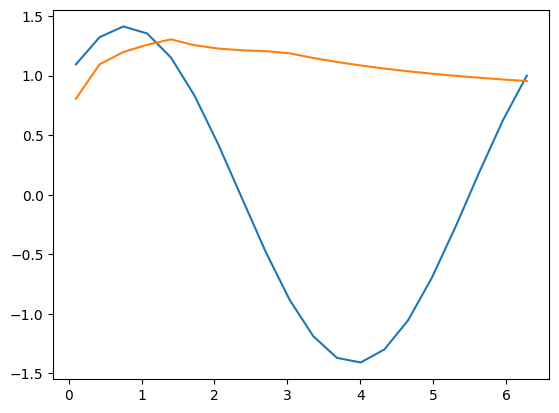

In [115]:
from matplotlib import pyplot as plt

plt.plot(t_axis, a_solutions)
plt.plot(t_axis, (np.array([2] * len(q0_solutions)) - q0_solutions) / np.sqrt(2))
plt.show()

In [ ]:
amps = [ps.amplitude for ps in res.result()[0].value.parsed_state_vector if ps["approximator"] == 0 and ps["ancilla"] == 0]
Nsq = sum(Cs)
total_prob = (amps[0]*amps[0].conjugate() + amps[1] * amps[1].conjugate())
Xt = np.sqrt((amps[0]*amps[0].conjugate() / total_prob).real)
Xt*np.sqrt(Nsq)

In [ ]:
analytical = np.cos(t) + np.sin(t)
quantum = (np.sqrt(complex(sv["0000"])*1j) + np.sqrt(complex(sv["0001"])*1j)).real
print(f"Analytical: {analytical:.4f}; Quantum: {quantum:.4f}")

In [ ]:
np.cos(3 * np.pi / 8) + np.sin(3 * np.pi / 8)

In [141]:
t = 2 * np.pi / 3
@qfunc
def main(phi: Output[QBit]):
    allocate(1, phi)
    H(phi)
    RY(2*t, phi)

In [142]:
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
quantum_model = create_model(main,
    execution_preferences=ExecutionPreferences(
        num_shots=1024, backend_preferences=backend_preferences
    )
)
quantum_program = synthesize(quantum_model)
res = execute(quantum_program)
analytical = np.cos(t) + np.sin(t)
amps = np.array([ps.amplitude for ps in res.result()[0].value.parsed_state_vector]) * norm([1.0, 1.0])
print(f"Analytical={analytical}; Quantum amps={amps}")
print(complex(res.result()[0].value.state_vector["1"]) * norm([1.0, 1.0]))


Analytical=0.36602540378443893; Quantum amps=[-1.3660254+0.j  0.3660254+0.j]
(0.36602540378443965+0j)
